# Sparse regression for the recovery of nonlinear dynamics
#### ``SINDy, thoughts on correlated variables and optimization algorithms``

#### Final Project - Statistical Learning 2022/2023

Diogo Carvalho (78456)

diogo.d.carvalho@tecnico.ulisboa.pt

## Introduction

*Notation* 
- $\theta$ - scalar , $\boldsymbol{\theta}$ - (column) vector , $\boldsymbol{\Theta}$ - matrix , $\Theta$ - set
- $f(\mathbf{x})$ / $F(\mathbf{x})$ - scalar function , $\mathbf{f}(\mathbf{x})$ / $\mathbf{F}(\mathbf{X})$ - vector field

### Regularized Linear Regression

Regularized least squares methods are commonly used to solve both underdetermined ($n < p$) and overdetermined ($n > p$) linear systems of equations. They attempt to solve the following class of optimization problems:

\begin{equation}
\min_{\mathbf{w} \ \in \ \mathbb{R}^p} \frac{1}{2n} \left\|\mathbf{X}\mathbf{w} - \mathbf{y} \right\|^2_2 + \lambda R(\mathbf{w}, \boldsymbol{\theta})
\end{equation}

where $\mathbf{y} \in \mathbb{R}^{n}$ represents the observed target variables, $\mathbf{X} \in\mathbb{R}^{n\times p}$ the corresponding free variables measurements, $\mathbf{w} \in \mathbb{R}^p$ the model parameters we want to estimate, $R \colon \mathbb{R}^p \to \mathbb{R}$ a regularizing function parameterized by $\boldsymbol{\theta} \in \mathbb{R}^{P}$, and $\lambda \in \mathbb{R}$ the regularization weight. 

Depending on the constraints one wants to impose on the weight vector there exist an extensive set of possible regularizations to use. A few common examples are provided below (for more information see Chapter 11 of [[1](#bib)])

#### Ridge Regression ($\ell_2$)

In the case off ridge regression the regularization term is given by the square of the $\ell_2$-norm:

\begin{equation}R_{L2}(\mathbf{w}) = \| \mathbf{w} \|_2^2 = \sum_{i=1}^p w_i^2 \end{equation}

The solution for the ridge regression problem has a closed form given by:

\begin{equation}\hat{\mathbf{w}}=\left(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I}\right)^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y}\end{equation}

where $\mathbf{I}$ represents the identity matrix.

This kind of regularization is commonly used to solve under-determined problems (since the solution of the ridge regression problem is unique) or mitigating the effect of highly correlated variables (as it helps stabilizing the inversion of the ill-conditioned matrix). Additionally, by penalizing for larger weight values, this regularization can also help prevent overfitting the data.

#### LASSO - Least absolute shrinkage and selection operator ($\ell_1$)

When attempting to retrieve a sparser model, i.e. force non-relevant coefficients to zero which can be useful for interpretability purposes, a common solution is to use the LASSO regression. The LASSO penalizes the $\ell_1$ norm of the weights:

\begin{equation}R_{L1}(\mathbf{w}) = \| \mathbf{w} \|_1 = \sum_{i=1}^p |w_i| \end{equation}

Even though the number of non-zero terms does not explicitily appear in the regularization term, it is possible to get a geometric intuition on why this happens based on the constraint surfaces defined by the $\ell_1$-norm (see Figure 1).

Unlike ridge regression, there is no close form solution for the LASSO case and its associated cost is not differentiable at $ w_i=0$. However there exists a broad range of optimization algorithms with guaranteed convergence properties to solve this convex problem (see chapter 11.4.9 of [[1](#bib)]).

Although LASSO can provide sparse solutions, there exist scenarios where it might actually provide worse interpretability than ridge regression. In particular for:

1. *Strongly correlated variables* - If the target variable depends of strongly correlated free variables then there exist infinite solutions for the LASSO problem (as any combination of the correlated terms is a viable solution). In such case, while Ridge regression would push all coefficients to the same value (since this minimizes the $\ell_2$ norm), LASSO would simply provide a "random" combination of the subset of correlated terms.


2. *Underdetermined problems* - When $n < p$ LASSO can select at most $n$ active terms eventhough more might be associated with the outcome.

For these reasons several variants have been proposed that try to tackle these problems.

#### Elastic Net ($\ell_1 + \ell_2$)

Elastic Net tries to tackle the aforementioned problem by combining the $\ell_1$ and $\ell_2$ norms:

\begin{equation}R_{EN}(\mathbf{w}) = \| \mathbf{w} \|_1 + \lambda_2 \| \mathbf{w} \|_2\end{equation}

This provides a balance between retrieving a sparse solution, causes the grouping of correlated variables coefficients (due to the $\ell_2$ term), and extends the applicability of LASSO to underdetermined problems. However it introduces an additionaly regularization parameter that needs to be tuned. 

#### $\ell_0$-penalized Regression

In the extreme case where one wants to obtain the solution with the smallest possible amount of active terms (best subset selection), we are attempting to solve the regression problem for the $\ell_0$-norm:

\begin{equation}R_{L0}(\mathbf{w}) = \| \mathbf{w} \|_0 = |\{w_i: w_i \neq 0\}|\end{equation}

However this norm is not convex and the optimization task becomes an NP-hard problem. Usually one can relax the constraint (falling back to something more similar to LASSO/Ridge) or use greedy approaches to approximate the optimal solution (not guaranteed to find global optimum). A review of some algorithms that attempt to solve this problem is available in [[9](#bib)].

<br>
<br>

<center><img src="./img/norms.jpg" ...></center>
<br>
<left><b>Figure 1</b>: <i>"Penalty functions (blue) with associated contour plots (red) of the values of the least-squares objective function in two dimensions. Each penalty function defines a different regularization scheme. The intersection of the contour plot with the penalty function as the latter achieves its maximum allowed value under the specified degree of regularization defines the regularized solution. Sparsity is achieved when this intersection occurs along an axis, for which a parameter takes a value of zero, with the different penalties promoting this to a greater or lesser degree."</i>. Elastic Net is shown as (EN). <br> Figure and description retrieved from C. Sabett <i>et al.</i> [<a href=https://onlinelibrary.wiley.com/doi/10.1002/cmr.a.21427>Source] </left>



***

## Sparse Identification of Nonlinear Dynamics (SINDy)

Consider a dynamical system whose evolution can be described by:

\begin{align}
\frac{d}{dt}\mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t))
\label{eq:ds} \tag{1}
\end{align}

where $\mathbf{x}(t) \in \mathbb{R}^{d}$ represents the state of the system at time $t$, and $\mathbf{f} \colon \mathbb{R}^d \to \mathbb{R}^d$ a function which constrains the dynamics of the system. 

In the case where the dynamics are not known $\textit{a-priori}$, but one has access to a set of observable observables $\{x_i\}$ at different time-steps, it is possible to use machine learning algorithms to recover a symbolic representation of $\mathbf{f}$. Currently, there are two main approaches for this task, sparse regression and symbolic regression techniques. In the work we focus on the first set.

Sparse regression approaches designed for this task assume that one can write $\mathbf{f}$ as a sum over a finite number of pre-defined basis functions:

\begin{equation}
\mathbf{f}(\mathbf{x}) = \sum_{i=1}^p \xi_i \boldsymbol{\theta}_i(\mathbf{x})
\end{equation}

and $\Theta(\mathbf{x}) = \{\boldsymbol{\theta}_i(\mathbf{x}) \in \mathbb{R}^{d}, i=1, .., p\}$ defines the set of basis functions and $\boldsymbol{\xi} = \{\xi_i, \in \mathbb{R}, i=1, ..., p\}$ the corresponding weights. 

Given a set of observables $X = \{\mathbf{x}_i, i=1, ..., n\}$, and assuming the corresponding instantenous derivative $\dot{X} = \{\dot{\mathbf{x}}_i, i=1, ..., n\}$ can be measured/approximated  (e.g. using a finite difference scheme) one can adapt $\eqref{eq:ds}$ to:

\begin{equation}
\dot{\mathbf{X}} = \boldsymbol{\Theta}(\mathbf{X})\boldsymbol{\xi} + \eta\mathbf{Z}
\end{equation}

where the set elements are stacked row-wise and the extra $\eta\mathbf{Z}$ term accounts for the measurement noise (e.g. matrix of independent identically distributed Gaussian noise).

The goal is then to estimate the weight vector $\boldsymbol{\xi}$ based on the observables in order to retrieve the symbolic expression for the dynamics of the system:

\begin{equation}
\dot{\mathbf{x}} = \Theta{(\mathbf{x})}\boldsymbol{\xi}
\end{equation}

_Note_: slight abuse of notation, $\mathbf{\Theta}(\mathbf{X})$ represents in matrix format the value of the basis functions at the measured datapoints $\mathbf{X}$ while $\Theta(\mathbf{x})$ represents the set of symbolic expressions for the basis functions.

For purposes of interpretability, and based on the intuition that only a few basis function should actually contribute to the dynamics, this problem can be expressed as an overdetermined sparse regression problem (usually $n >> p$) in the presence of noise. This can be formulated as:

\begin{equation}
\min_{\boldsymbol{\xi} \ \in \ \mathbb{R}^p} \frac{1}{2n} \left\|\boldsymbol{\Theta}(\mathbf{X})\boldsymbol{\xi} - \dot{\mathbf{X}} \right\|^2_2 + \lambda R(\boldsymbol{\xi})
\end{equation}

where $R(\cdot)$ represents some regularization function. 

The core of the SINDy algorithm (and derivates) [[2,3](#bib)] is therefore "simply" the reformulation of the discovery of diferential equations symbolic formulas from data as a well estabilished sparse regression optimization problem. 

Althought there exist several versions of SINDy [[4](#bib)], in the subsequent sections we will be mostly mentioning the original version [[2](#bib)] which was soon adapted to the partial differential equations case [[3](#bib)] by simply considering that $\mathbf{f}$ (and therefore $\Theta$) might contain partial derivatives of $\mathbf{x}$ with respect to some physical quantities (e.g. space, velocity) which one can measure or compute using finite-difference schemes.

#### Interpretability > Accuracy ($\ell_0$ regularization and optimization algorithms)

The main goal of sparse regression for PDE retrieval is interpretability (i.e. we want to understand the underlying dynamics). For this purpose the original SINDy algorithm used L0 regularization:

\begin{equation}R(\boldsymbol{\xi}) = \left\|\boldsymbol{\xi}\right\|_0 = |\{\xi_i: \xi_i \neq 0\}| 
\end{equation}

i.e. the norm is given by the number of active terms. As previously mentioned, the main benefit of this norm is that it reduces the number  However, the $\ell_0$-norm is not convex and the optimization task becomes an NP-hard problem.

To attempt to find an approximate solution to the problem the authors propose to use the following greedy optimizations algorithms.

#### Sequentially Thresholded Least Squares (STLS)

The STLS proposed in the original SINDy paper [[2](#bib)] can be summarized as follows:

- Start with the Least Square (LS) solution for $\boldsymbol{\xi}$
- Until the number of non-zero coefficients does not change:
    - Set all non-zeros coefficients smaller than a pre-defined threshold to zero
    - Perform a LS regression considering only the non-zeroed coefficient terms

This algorithm has later been shown to rapidly approximate local minimizers of the $\ell^0$-
penalized least-squares problem, resulting in fast conversion rates to a fixed point [[5](#bib)]. However, it is not guaranteed to find the optimal solution (and does not guarantee a fixed number of retrieved non-zero parameters).

#### Sequentially Thresholded Ridge Regression (STRidge)

In later works [[3](#bib)], the authors modified the STLS algorithm by substituting the Least Square estimate with a Ridge regression (thus coining the new version STRidge). The main reason for this change is that replacing the LS with the Ridge estimate helps to stabilize the algorithm for ill-posed problems (e.g. extremely correlated variables).

***

# Experiments
### ``Discovery of the Vlasov Equation from Particle-in-Cell (PIC) Simulations``

## The impact of regularization

We will now illustrate how we can use sparse regression techniques for the recovery of the underlying PDE, and how the choice of regularization affects the retrieved PDE. We will be using the data from E. P. Alves [[6](#bib)] for which a SINDy like algorithm used to infer the kinetic Vlasov equation:

\begin{equation}
\partial_t f = -v \partial_x f + \frac{e}{m_e} E \partial_v f
\end{equation}

from PIC simulation data of the plasma two-stream instability [[7](#bib)]. The Vlasov equation is not explicitly solved by the PIC code (which computes individual particle trajectories and the self-generated electromagnetic fields), but the collective dynamics of the weakly collisional plasma (i.e. the evolution of the distribution function in phasespace) are expected to follow this equation.

**Quantities** 
- $f$ - electron distribution function
- $v$ - electron velocity
- $E$ - electric field
- $e$ - electron charge
- $m_e$ - electron mass


_"The two-stream instability is a fundamental instability in weakly collisional plasmas that is triggered in the presence of counter-streaming beams of charged particles. It is recognized to play an important role in radio bursts in the solar corona, driving turbulence in magnetized plasmas, and much more."_, E. P. Alves [[Source](https://github.com/epalves/data-driven-plasma/blob/main/SR_Vlasov.ipynb)]


**Note**: The code used hereafter is inspired by: https://github.com/epalves/data-driven-plasma

In [1]:
import numpy as np
from ddplasma_utils import *
from vlasovdata_utils import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.linear_model import lasso_path, enet_path, orthogonal_mp, ridge_regression

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=False)

%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Download Data

In [2]:
# automatically download data
# can also manually download from https://doi.org/10.5281/zenodo.7968600
!mkdir data
!wget -P data https://zenodo.org/record/7968601/files/fld_data.pkl
!wget -P data https://zenodo.org/record/7968601/files/phase_space_data.pkl

--2023-06-14 23:28:55--  https://zenodo.org/record/7968601/files/fld_data.pkl
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473173 (462K) [application/octet-stream]
Saving to: ‘data/fld_data.pkl’

fld_data.pkl        100%[===================>] 462,08K  1,06MB/s    in 0,4s    

2023-06-14 23:28:58 (1,06 MB/s) - ‘data/fld_data.pkl’ saved [473173/473173]

--2023-06-14 23:28:58--  https://zenodo.org/record/7968601/files/phase_space_data.pkl
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120329405 (115M) [application/octet-stream]
Saving to: ‘data/phase_space_data.pkl’

phase_space_data.pk 100%[===================>] 114,75M   711KB/s    in 2m 43s  

2023-06-14 23:31:44 (721 KB/s) - ‘data/phase_space_data.pkl’ saved [120329405/1203

In [3]:
# Dictionary that stores 1D electric field at different time-step E[t_i, x_i] (2D)
fld_data = load_obj('./data/fld_data.pkl')
# Dictionary that stores 2D electron distribution function F[t_i, u_i, x_i] (3D)
ps_data = load_obj('./data/phase_space_data.pkl') 

#### [Extra] Visualize the instability growing

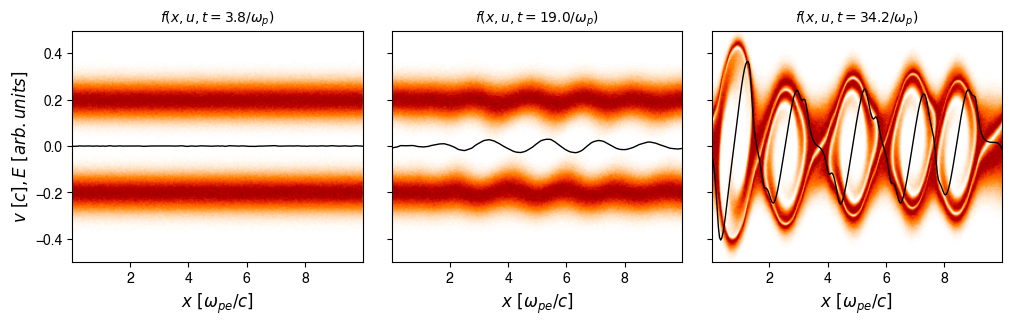

In [4]:
# pick time steps 
i_ts = [0,200,400] 

# plot
fig, ax = plt.subplots(1, len(i_ts), figsize=(4*len(i_ts), 3), gridspec_kw={'wspace':0.1})

x_arr = ps_data['x']
u_arr = ps_data['u']
t_arr = ps_data['t']

dx = x_arr[1] - x_arr[0]
du = u_arr[1] - u_arr[0]
dt = t_arr[1] - t_arr[0]

for i, i_t  in enumerate(i_ts):
    
    ax[i].set_title(r'$f(x,u,t = ' + str(round(t_arr[i_t],2)) + '/\omega_p)$')
    
    ax[i].imshow(ps_data['F'][i_t, :, :], origin='lower', 
                 extent=[x_arr[0], x_arr[-1], u_arr[0], u_arr[-1]], 
                 aspect='auto', cmap = 'gist_heat_r', vmax = 7)
    

    ax[i].plot(fld_data['x'], 3*fld_data['E'][i_t,:], c = 'k', lw = 1.)

for ia, a in enumerate(ax):
    a.set_xlabel(r'$x\ [\omega_{pe}/c]$', fontsize=12)
    if ia == 0:
        a.set_ylabel(r'$v\ [c], E\ [arb. units]$', fontsize=12)
    else:
        a.set_yticklabels([])
        
plt.show()

In the figures above one can see the evolution of the distribution function ($f$)  over time (red density plot) and the corresponding electric field (overlayed black line). The evolution of the instability is clearly visible, from the starting two well defined conter-propagating beams (one with $v >0$ other with $v<0$), to the later phase mixing.

### Build library of candidate terms $\mathbf{\Theta}$

The routine below constructs the target $\mathbf{y}$ vector and $\mathbf{\Theta}$ matrix of the linear system of equations $\mathbf{y} = \mathbf{\Theta} \boldsymbol{\xi}$ which we want to solve.

**Notation**: 
- 'A_b' - partial derivative of A with respect to b

**Variables**:
- Y - column vector with values of $\partial_t f$ at the randomly sampled data points
    
- Theta - matrix with the library of candidate terms. Each column corresponds to a given candidate PDE term (e.g. F, F_x, v*F_x), and each row is its value at a sampled data point. Here we consider polynomial nonlinearities up to second order (power = 2).
- description - array of string labels for each candidate PDE term

For more information on how the vocabulary terms are constructed refer to:  https://github.com/epalves/data-driven-plasma

Selecting Random Colocation Points


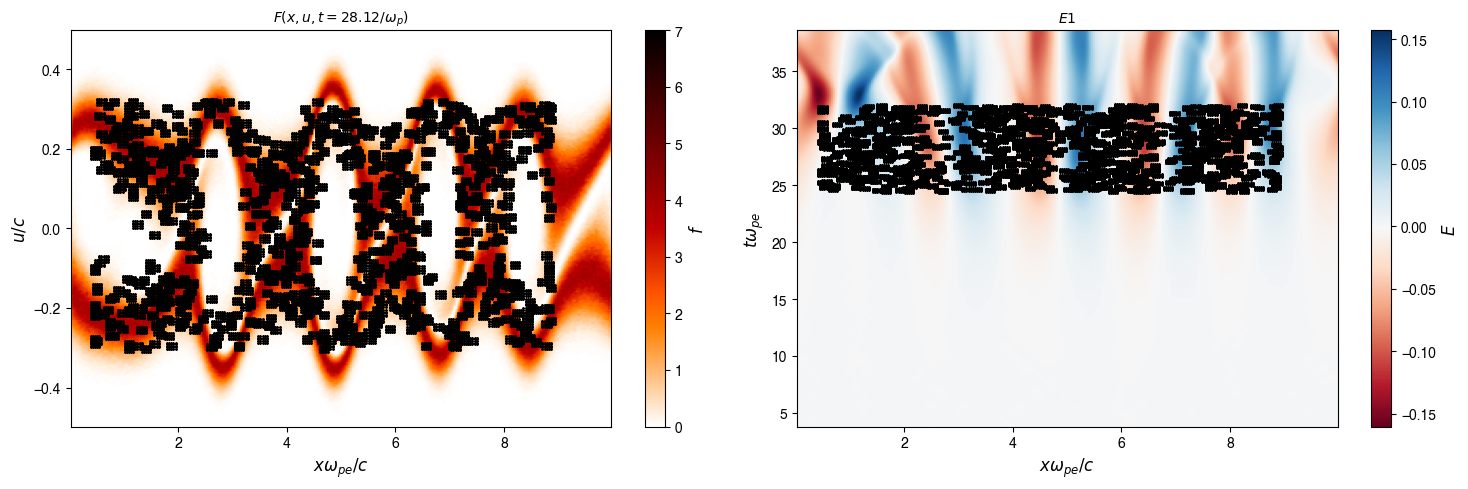

Evaluating features...
Progress:  0.0 %
Progress:  10.0 %
Progress:  20.0 %
Progress:  30.0 %
Progress:  40.0 %
Progress:  50.0 %
Progress:  60.0 %
Progress:  70.0 %
Progress:  80.0 %
Progress:  90.0 %
Done.
Bulding Theta and Y for sparse regression...
Building Theta matrix...
Calculating Y...
Done.

#Terms: 66
['1', 'F', 'E', 'v', 'x', 'F_x', 'F_xx', 'E_x', 'E_xx', 'F_u', 'F_uu', 'FF', 'FE', 'Fv', 'Fx', 'FF_x', 'FF_xx', 'FE_x', 'FE_xx', 'FF_u', 'FF_uu', 'EE', 'Ev', 'Ex', 'EF_x', 'EF_xx', 'EE_x', 'EE_xx', 'EF_u', 'EF_uu', 'vv', 'vx', 'vF_x', 'vF_xx', 'vE_x', 'vE_xx', 'vF_u', 'vF_uu', 'xx', 'xF_x', 'xF_xx', 'xE_x', 'xE_xx', 'xF_u', 'xF_uu', 'F_xF_x', 'F_xF_xx', 'F_xE_x', 'F_xE_xx', 'F_xF_u', 'F_xF_uu', 'F_xxF_xx', 'F_xxE_x', 'F_xxE_xx', 'F_xxF_u', 'F_xxF_uu', 'E_xE_x', 'E_xE_xx', 'E_xF_u', 'E_xF_uu', 'E_xxE_xx', 'E_xxF_u', 'E_xxF_uu', 'F_uF_u', 'F_uF_uu', 'F_uuF_uu']

Theta:  (1000, 66)
Y:  (1000, 1)


In [5]:
# this routine randomly selects 1000 cubic volumes of 5dx*5dv*5dt each
print('Selecting Random Colocation Points')
points = get_sampling_points(
    ps_data, 
    num_tux0 = [10, 10, 10], 
    vol_tux = [5, 5, 5], 
    lowerbound_t = 270, 
    upperbound_t = 370
)

plot_sample_points_on_data(ps_data, fld_data, points)

print('Evaluating features...')
features, y_quants = collect_sample_data_and_derivatives(ps_data, fld_data, points, O = 2)
print('Done.')

X_data_descr = ['1',
                'F',    'E',    'v',   'x',
                'F_x',  'F_xx', 'E_x', 'E_xx',
                'F_u', 'F_uu'
               ]

print('Bulding Theta and Y for sparse regression...')

Theta, Y, description = build_Theta_and_Y(features, y_quants, 
                                          X_data_descr, y_data_descr = 'F_t', 
                                          power = 2, integration_type = 'vol')
print('Done.')

# This is the description of each column in Theta (each candidate PDE term)
print()
print("#Terms:", len(description))
print(description)
print()
print("Theta: ", Theta.shape)
print("Y: ", Y.shape)

### Comparison between different regularizations (Ridge, LASSO, ElasticNet, $\ell_0$)

In the following block of code we use different regularizations to attempt to extract the coefficients of the underlying PDE. 

The goal is not to find the best performing hyper-parameters for each algorithm, but to compare the impact of the different regularizations on the sparsity of the retrieved solutions as well as the bias of the estimates. For simplicity we are using the full dataset without performing any cross validation since we only wish to perform a qualitative comparison.

For the Ridge, LASSO and Elastic Net we use the [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) implementation of the algorithms, while for the $\ell_0$-norm case we re-implement the STLS and STRidge algoithms based on the original SINDy and PDE-FIND papers.

We perform a scan over a parameter $\alpha$ which has different meanings depending on the algorithm:

- Ridge - $\ell_2$ penalty coefficient
- LASSO - $\ell_1$ penalty coefficient
- Elastic Net - $\ell_1$ and $\ell_2$ penalty coefficients (chose this balance for a more striking difference with LASSO)
- STLS - threshold value at which coefficients are set to zero
- STRidge - same as STLS, $\ell_2$ penalty coefficient of ridge regression is set to $2$ (chosen to provide some difference relative to STLS)

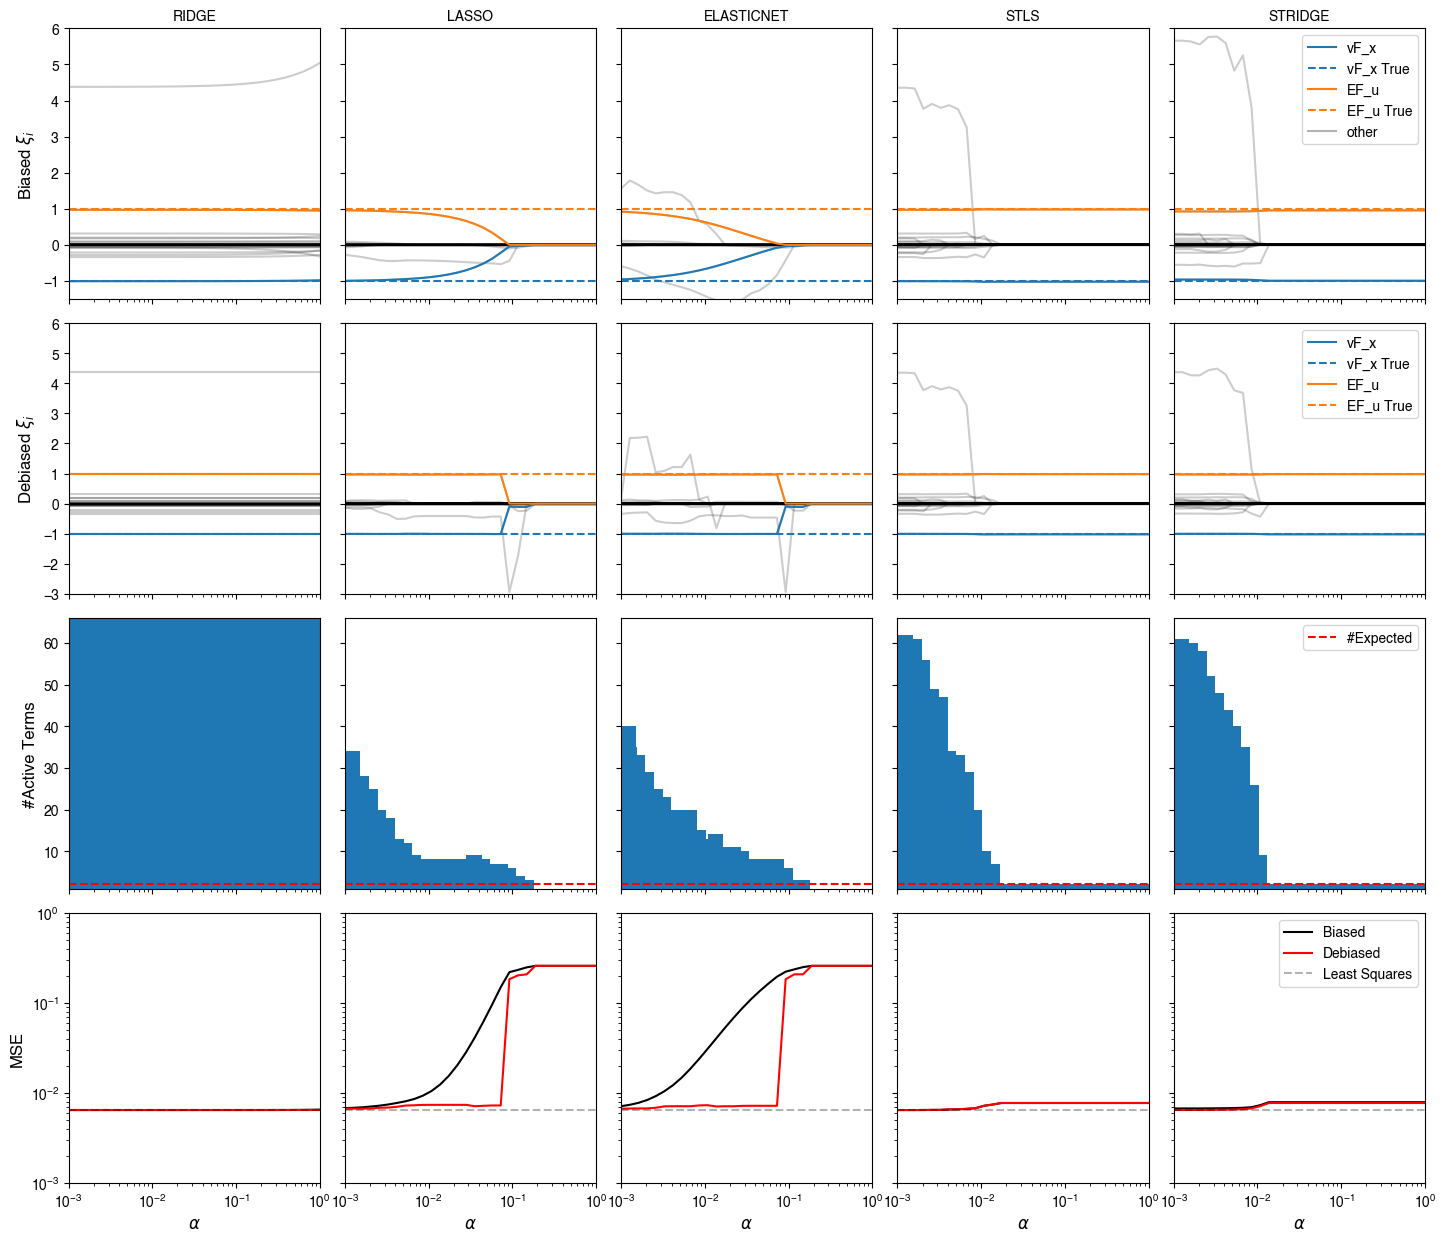

In [6]:
# aux to normalize columns of Theta
Theta_Norm = np.sqrt(np.var(Theta, axis=0))
Theta_Norm[0] = 1

alphas = np.logspace(-3, 0, 30)[::-1]
coefs = dict()
coefs_ls = ridge_regression(Theta/Theta_Norm, Y[:,0], 0)

coefs['ridge'] = np.array([ridge_regression(Theta/Theta_Norm, Y[:,0], a) for a in alphas])
coefs['lasso'] = lasso_path(Theta/Theta_Norm, Y[:,0], alphas=alphas)[1].T
coefs['elasticnet'] = enet_path(Theta/Theta_Norm, Y[:,0], alphas=alphas*3., l1_ratio=1/3.)[1].T
coefs['stls'] = np.array([STRidge(Theta/Theta_Norm, Y[:,0], alpha=0, threshold=a) for a in alphas])
coefs['stridge'] = np.array([STRidge(Theta/Theta_Norm, Y[:,0], alpha=2, threshold=a) for a in alphas])

def get_unbiased_coefs(X, y, coefs):
    coefs_unbiased = np.zeros_like(coefs)
    for i in range(len(alphas)):
        nonzero = coefs[i] != 0
        coefs_unbiased[i, nonzero] = np.linalg.lstsq(X[:,nonzero], y, rcond=None)[0]
    return coefs_unbiased

coefs_unbiased = dict()
for key in coefs:
    coefs_unbiased[key] = get_unbiased_coefs(Theta/Theta_Norm, Y[:,0], coefs[key])
    
correct_params = ['vF_x', 'EF_u']
correct_values = {'vF_x': -1, 'EF_u':1}
correct_colors = {'vF_x': 'tab:blue', 'EF_u': 'tab:orange'}

for key in coefs:
    coefs[key] /= Theta_Norm
    coefs_unbiased[key] /= Theta_Norm
    
fig, ax = plt.subplots(4, len(coefs), figsize=(3.5*len(coefs), 3*5), gridspec_kw={'wspace':0.1, 'hspace':0.09})
    
for i, key in enumerate(coefs):
    
    ax[0, i].set_title(key.upper())
    
    ##### biased coefs
    ax[0,i].plot(alphas, coefs[key], 'k-', alpha=0.2)
    
    for cp in correct_params:
        ax[0,i].plot(alphas, coefs[key][:, description.index(cp)], color=correct_colors[cp], label=cp)
        ax[0,i].axhline(correct_values[cp], color=correct_colors[cp], ls='--', label=cp + ' True')
    
    ax[0,i].set_ylim([-1.5, 6])
    
    ##### unbiased coefs
    ax[1,i].plot(alphas, coefs_unbiased[key], 'k-', alpha=0.2)
    
    for cp in correct_params:
        ax[1,i].plot(alphas, coefs_unbiased[key][:, description.index(cp)], color=correct_colors[cp], label=cp)
        ax[1,i].axhline(correct_values[cp], color=correct_colors[cp], ls='--', label=cp + ' True')
    
    ax[1,i].set_ylim([-3, 6])
    
    
    n_active = np.sum(coefs[key] != 0, axis=-1)
    ax[2,i].bar(alphas, n_active, width=list(2*(alphas[:-1]-alphas[1:])) + [min(alphas)])
    ax[2,i].axhline(len(correct_values), color='red', ls='--', label='#Expected')
    ax[2,i].set_ylim(1, Theta.shape[-1])
    
    mse_coefs = np.mean((Y - np.dot(Theta, coefs[key].T))**2, axis=0)
    mse_unbiased = np.mean((Y - np.dot(Theta, coefs_unbiased[key].T))**2, axis=0)
    
    ax[3,i].plot(alphas, mse_coefs, color='k', label='Biased')
    ax[3,i].plot(alphas, mse_unbiased, color='r', label='Debiased')
        
    ax[3,i].axhline(np.mean((Y[:,0] - np.dot(Theta/Theta_Norm, coefs_ls))**2), color='k',ls='--', alpha=0.3, label='Least Squares')
    ax[3,i].set_yscale('log')
    ax[3,i].set_ylim(1e-3, 1e0)

    if i != 0:
        for a in ax[:,i]:
            a.set_yticklabels([])
            
        if i == len(coefs) - 1:
            ax[0,i].plot([], [], color='k', ls='-', alpha=0.3, label="other")
            for a in ax[:,i]:
                a.legend()
    else:  
        ax[0,i].set_ylabel(r'Biased $\xi_i$')
        ax[1,i].set_ylabel(r'Debiased $\xi_i$')
        ax[2,i].set_ylabel('#Active Terms')
        ax[3,i].set_ylabel('MSE')
    
    
    ax[-1,i].set_xlabel(r'$\alpha$')

    
for a in ax.ravel():
    a.set_xscale('log')
    a.set_xlim(min(alphas), max(alphas))

for a in ax[:-1].ravel():
    a.set_xticklabels([])
        
plt.show()

The following observations are withdrawn
#### Sparsity

- Except for Ridge regression, all other promote sparse solutions. 
- Due to their greedy nature STLS/STRidge are able to isolate the 2 (correct) meaningful terms.
- Due to the $\ell_1$ penalization term LASSO/Elastic Net only identify the meaningful terms. However this only happens at regularization penalizations for which other spurious terms are already active.

#### Bias

- Appart from STLS all other produce methods produce biased estimates (due to the $\ell_1$ and $\ell_2$ terms which shrink the coefficients values).
- This bias can be removed _a posteriori_ by performing a Least Squares fit with the non-zero coefficients.


These results highlight once again the importance, for the task of PDE symbolic retrival, of chosing the correct type of regularization.

## Complexity, Pareto Curves, and Backward vs Forward Greedy Methods

The greedy algorithms proposed by SINDy to solve the $\ell_0$-penalized problem do not allow one to define how many non-zero coefficients the model is allowed to have, i.e. they do not provide a solution for the best subset selection problem:

\begin{equation}
\min_{\boldsymbol{\xi} \ \in \ \mathbb{R}^p} \frac{1}{2n} \left\|\mathbf{\Theta}\boldsymbol{\xi} - \mathbf{y} \right\|^2_2 \quad \text{subject to} \; |\boldsymbol{\xi}| \leq k 
\end{equation}

However one can slightly modify them according to the following scheme 

#### STRidge_1by1 - (Backward Greedy Optimization Algorithm)

- Initialize $\boldsymbol{\xi}$ with Ridge estimate
- Until all coefficients are zeroed
    - Zero current smallest coefficient (equivalent to updating threshold to the smallest coefficient)
    - Perform Ridge regression using non-zeroed coefficient terms

This generates basically a *backward* greedy optimization scheme since we iteratively remove elements from the active subset. 

Re-writing the algorithm in this manner also allows us to create a hierarchy of increasingly complex functions (complexity defined as number of non-zero terms) which can be interpreted as something similar to a pareto-curve, thus providing better insight into the impact of adding new terms into the model. Note however that we are not guaranteed to have found the best performing solution at each level of complexity, and for this reason it might be interesting to compare the found solutions with other best-subset selection optimization algorithms.

One of commonly used alternative for best subset selection is the Orthogonal Matching Pursuit (OMP) algorithm [[8](#bib)]. This is a *forward* greedy optimization algorithm, since active terms are appended (instead of removed) at each iteration. The structure of the OMP algorithm is summarized below.

#### Orthogonal Matching Pursuit - (Forward Greedy Optimization Algorithm)

- Start with an empty set of active (non-zero) terms $\Theta_{act} = \{\}$
- Initialize the residual to $\mathbf{r}=\mathbf{y}$
- For $t$ in $1,..,k$:
    - From the set of non-active terms $\Theta \setminus \ \Theta_{act}$, find the one for which its measurements maximize the dot product with the residuals $<\mathbf{r}_t,\boldsymbol{\theta}_i>$
    - Append the found maximizing term to the active set
    - Find LS estimate for active term weights $\boldsymbol{\xi}_{active} = \text{arg}\!\min_{\boldsymbol{\xi}}\left\|\mathbf{\Theta}_{act}\boldsymbol{\xi} - \mathbf{r}_t\right\|_2$  
    - Update residual $\mathbf{r} \leftarrow \mathbf{r} -  \mathbf\Theta_{act}\boldsymbol{\xi}_{act}$
    
To perform a comparison we produce solutions for the Vlasov data using k-fold cross validation (one hierarchy of models per k-fold). 

For simplicity we set the $\ell_2$ penalty of ridge regression to zero, which means we are using a LS estimate instead of the Ridge estimate (i.e. STRidge_1by1 == STLS_1by1)

In [7]:
alg_results = dict()
K = 10
alg_results['stls'] = Kfold_Regression__1by1(Theta = Theta, Y = Y, K_folds = K, normalize_Theta = True, algorithm='stridge', algorithm_params={'alpha':0})
alg_results['omp'] = Kfold_Regression__1by1(Theta = Theta, Y = Y, K_folds = K, normalize_Theta = True, algorithm='omp')

K-fold # 0
K-fold # 1
K-fold # 2
K-fold # 3
K-fold # 4
K-fold # 5
K-fold # 6
K-fold # 7
K-fold # 8
K-fold # 9
K-fold # 0
K-fold # 1
K-fold # 2
K-fold # 3
K-fold # 4
K-fold # 5
K-fold # 6
K-fold # 7
K-fold # 8
K-fold # 9


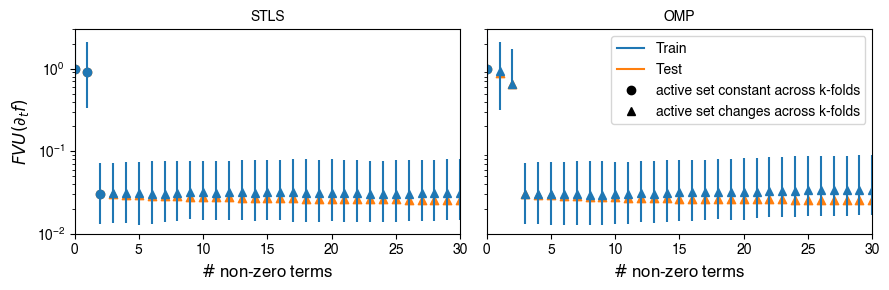

In [8]:
fig,ax = plt.subplots(1,2, figsize=(2*4.5,3))

for i, key in enumerate(alg_results):
    _ = rebin_errors_vs_numnonzeroterms(alg_results[key], 'mse_train', if_display_modelformvariance = True, ax=ax[i])
    _ = rebin_errors_vs_numnonzeroterms(alg_results[key], 'mse_test', if_display_modelformvariance = True, ax=ax[i])

    ax[i].set_title(key.upper())
    ax[i].set_ylim(1e-2,3e0)
    ax[i].set_xlim(0,30)
    ax[i].set_xlabel(r'$\#$ non-zero terms')

    
patches = [mlines.Line2D([], [], color='tab:blue', label='Train'), 
           mlines.Line2D([], [], color='tab:orange', label='Test'),
           mlines.Line2D([], [], marker='o', ls='', color='k', label='active set constant across k-folds'),
           mlines.Line2D([], [], marker='^', ls='', color='k', label='active set changes across k-folds')]

patches += []
ax[1].legend(handles=patches)

ax[0].set_ylabel(r'$FVU(\partial_t f)$')
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

In the plots above we can observe the pareto curves obtained for the different optimization algorithms. The y-axis corresponds to the Fraction of Variance Unexplained (FVU) which is given by the ratio between the model’s mean squared error and the variance of the dependent variable $\partial_tf$. Error bars indicate the models performance variance across k-folds. 

The following conclusions are withdrawn:

**Sparsity**
- The STLS algorithm finds a sparser model (#non-zero = 2, correct) than the OMP (#non-zero = 3).

**Consistency**

- The STLS algorithm predicts the same active terms across different k-folds (for the sparser models), while the OMP does not.

To provide some insight into the active terms the different models predict we plot the active coefficients accross k-folds for the models from 1 to 3 active terms.

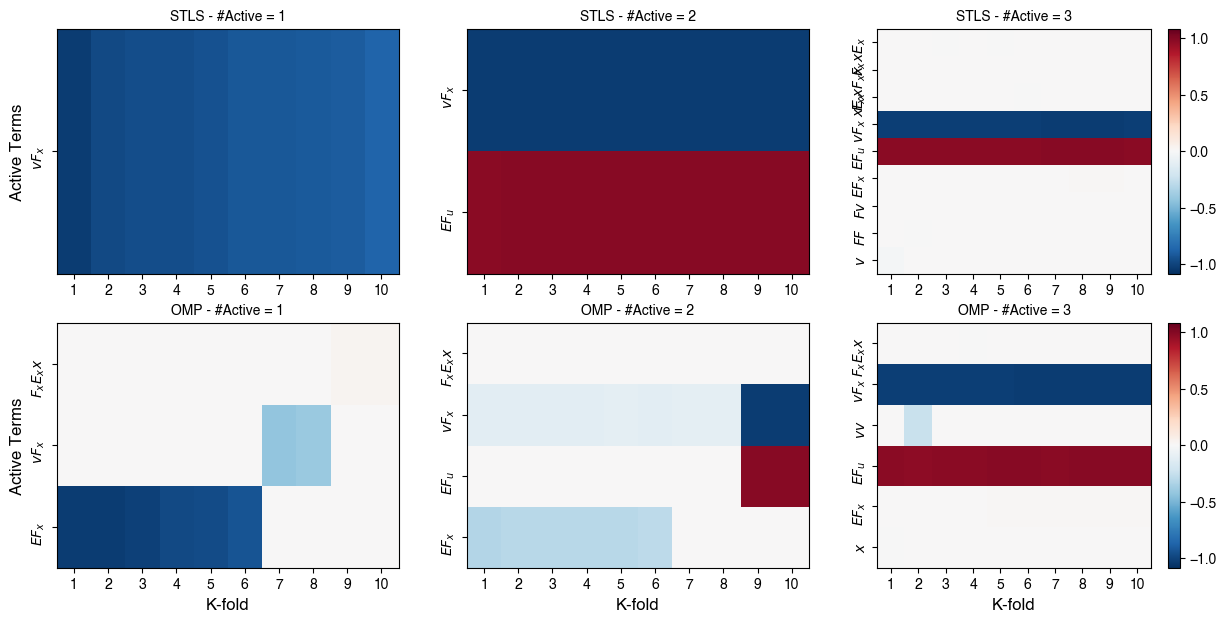

In [9]:
M = [1,2,3]

fig, ax = plt.subplots(len(alg_results), len(M), figsize=(len(M)*5,len(alg_results)*3.5))

for ik, key in enumerate(alg_results):
    for im, m in enumerate(M):
        
        ax[ik,im].set_title(key.upper() + ' - #Active = ' + str(m))
        
        unique_Mterm_models = np.unique(alg_results[key]['coeff_evol'][(alg_results[key]['num_non_zero_terms'][:,:] == m)], axis = 0)
        idx_non_zero_coefs_Mterm_models = (np.sum(unique_Mterm_models**2, axis=0)>0)

        max_abs_coef = np.max(np.abs(unique_Mterm_models))
        img = ax[ik,im].imshow(unique_Mterm_models[:,idx_non_zero_coefs_Mterm_models].T, origin='lower',
                   cmap = 'RdBu_r', aspect ='auto', vmin = -1.05*max_abs_coef, vmax = 1.05*max_abs_coef)

        # plt.yticks(range(sum(idx_non_zero_coefs_Mterm_models)), np.array(description)[idx_non_zero_coefs_Mterm_models], rotation='0')
        description_2 = [r'$'+descr +'$' for descr in description]
        ax[ik,im].set_yticks(range(sum(idx_non_zero_coefs_Mterm_models)), np.array(description_2)[idx_non_zero_coefs_Mterm_models], rotation='vertical')
        #plt.xlabel(str(M)+ ' term models')
        
        num_unique_models = unique_Mterm_models.shape[0]
        ax[ik,im].set_xlim(-0.5, num_unique_models-0.5)
        ax[ik,im].set_xticks(range(num_unique_models), range(1, num_unique_models+1))
        
        if im == len(M)-1:
            fig.colorbar(img, ax=ax[ik,im])
    
for a in ax:
    a[0].set_ylabel('Active Terms')

for a in ax[-1]:
    a.set_xlabel('K-fold')

The plots above demonstrate very clearly why the OMP algorithm fails. Since it builds the active terms set in a forward greedy fashion, wrongly inferred terms for the first step (#active = 1) are kept for later iterations even if their weight decreases significantly for more complex models (e.g. for 3 active terms the weights of 'EF_x' are practically zero).

This provides an indication that for the problem of PDE retrieval, backward (or mixed forward-backward) greedy algorithms might be better suited than forward methods. However, defining what is the "best" optimization algorithm is not a straightforward task and there exists a broad range of other families of optimization algorithms (not necessarily greedy) that might provide better convergence. Some examples of the different approaches are compiled in [[9](#bib)].

## Impact of Correlated Variables

The question we will tackle in this section is: What happens when there exist correlated variables in $\mathbf{\Theta}$ (which might or not be predictors for $\mathbf{y}$)?

To illustrate the problem we will introduce extra columns which are copies of the $E\partial_uf$ term ('EF_u') (which is a predictor for $\mathbf{y}$) to which we some gaussian noise was added. We name the new columns 'EF_uc{i}' with i ranging from 1 to 5.

In [11]:
# number new correlated variables
n_corr = 5 
# variable whis is copied
i_EF_u = description.index('EF_u')

np.random.seed(42)
corr_vars = np.repeat(Theta[:, i_EF_u:i_EF_u+1], n_corr, axis=-1)
corr_vars += 0.01*np.random.rand(*corr_vars.shape)

Theta_corr = np.concatenate([Theta, corr_vars], axis=-1)
description_corr = description + ['EF_uc' + str(i+1) for i in range(corr_vars.shape[-1])]

print()
print("#Terms:", len(description_corr))
print(description_corr)
print()
print("Theta: ", Theta_corr.shape)
print("Y: ", Y.shape)


#Terms: 71
['1', 'F', 'E', 'v', 'x', 'F_x', 'F_xx', 'E_x', 'E_xx', 'F_u', 'F_uu', 'FF', 'FE', 'Fv', 'Fx', 'FF_x', 'FF_xx', 'FE_x', 'FE_xx', 'FF_u', 'FF_uu', 'EE', 'Ev', 'Ex', 'EF_x', 'EF_xx', 'EE_x', 'EE_xx', 'EF_u', 'EF_uu', 'vv', 'vx', 'vF_x', 'vF_xx', 'vE_x', 'vE_xx', 'vF_u', 'vF_uu', 'xx', 'xF_x', 'xF_xx', 'xE_x', 'xE_xx', 'xF_u', 'xF_uu', 'F_xF_x', 'F_xF_xx', 'F_xE_x', 'F_xE_xx', 'F_xF_u', 'F_xF_uu', 'F_xxF_xx', 'F_xxE_x', 'F_xxE_xx', 'F_xxF_u', 'F_xxF_uu', 'E_xE_x', 'E_xE_xx', 'E_xF_u', 'E_xF_uu', 'E_xxE_xx', 'E_xxF_u', 'E_xxF_uu', 'F_uF_u', 'F_uF_uu', 'F_uuF_uu', 'EF_uc1', 'EF_uc2', 'EF_uc3', 'EF_uc4', 'EF_uc5']

Theta:  (1000, 71)
Y:  (1000, 1)


By introducing the strongly correlated variables, the matrix becomes ill-conditioned, which already hints that we will have trouble converging when using least squares (feel free decrease the noise level and verify it).

As mentioned in the intro, ridge regression is a common solution for this situation so we will be for now comparing the performance of STLS_1by1 and STRidge_1by1. As in the previous section we will look at the pareto curves and active terms in function of complexity.

In [12]:
corr_results = dict()
corr_results['stls'] = Kfold_Regression__1by1(Theta = Theta_corr, Y = Y, K_folds = 10, normalize_Theta = True, 
                                              algorithm='stridge', algorithm_params={'alpha':0})

corr_results['stridge'] = Kfold_Regression__1by1(Theta = Theta_corr, Y = Y, K_folds = 10, normalize_Theta = True, 
                                                 algorithm='stridge', algorithm_params={'alpha':1})

K-fold # 0
K-fold # 1
K-fold # 2
K-fold # 3
K-fold # 4
K-fold # 5
K-fold # 6
K-fold # 7
K-fold # 8
K-fold # 9
K-fold # 0
K-fold # 1
K-fold # 2
K-fold # 3
K-fold # 4
K-fold # 5
K-fold # 6
K-fold # 7
K-fold # 8
K-fold # 9


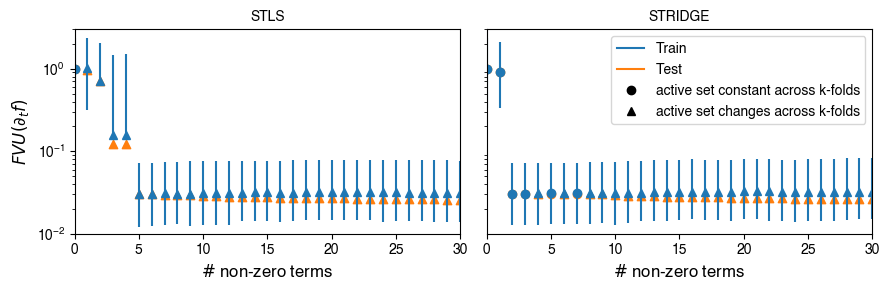

In [13]:
fig,ax = plt.subplots(1,2, figsize=(2*4.5,3))

for i, key in enumerate(corr_results):
    _ = rebin_errors_vs_numnonzeroterms(corr_results[key], 'mse_train', if_display_modelformvariance = True, ax=ax[i])
    _ = rebin_errors_vs_numnonzeroterms(corr_results[key], 'mse_test', if_display_modelformvariance = True, ax=ax[i])

    ax[i].set_title(key.upper())
    ax[i].set_ylim(1e-2,3e0)
    ax[i].set_xlim(0,30)
    ax[i].set_xlabel(r'$\#$ non-zero terms')

    
patches = [mlines.Line2D([], [], color='tab:blue', label='Train'), 
           mlines.Line2D([], [], color='tab:orange', label='Test'),
           mlines.Line2D([], [], marker='o', ls='', color='k', label='active set constant across k-folds'),
           mlines.Line2D([], [], marker='^', ls='', color='k', label='active set changes across k-folds')]

patches += []
ax[1].legend(handles=patches)

ax[0].set_ylabel(r'$FVU(\partial_t f)$')
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

From the plots above, it is already clear that the STLS fails to find a sparse solution (as expected) but the STRidge recovers the expected sparse model (although it is not clear yet how it is handling the correlated coefficients).

To better understand what is happening in both cases we can once again look at the predicted coefficients.

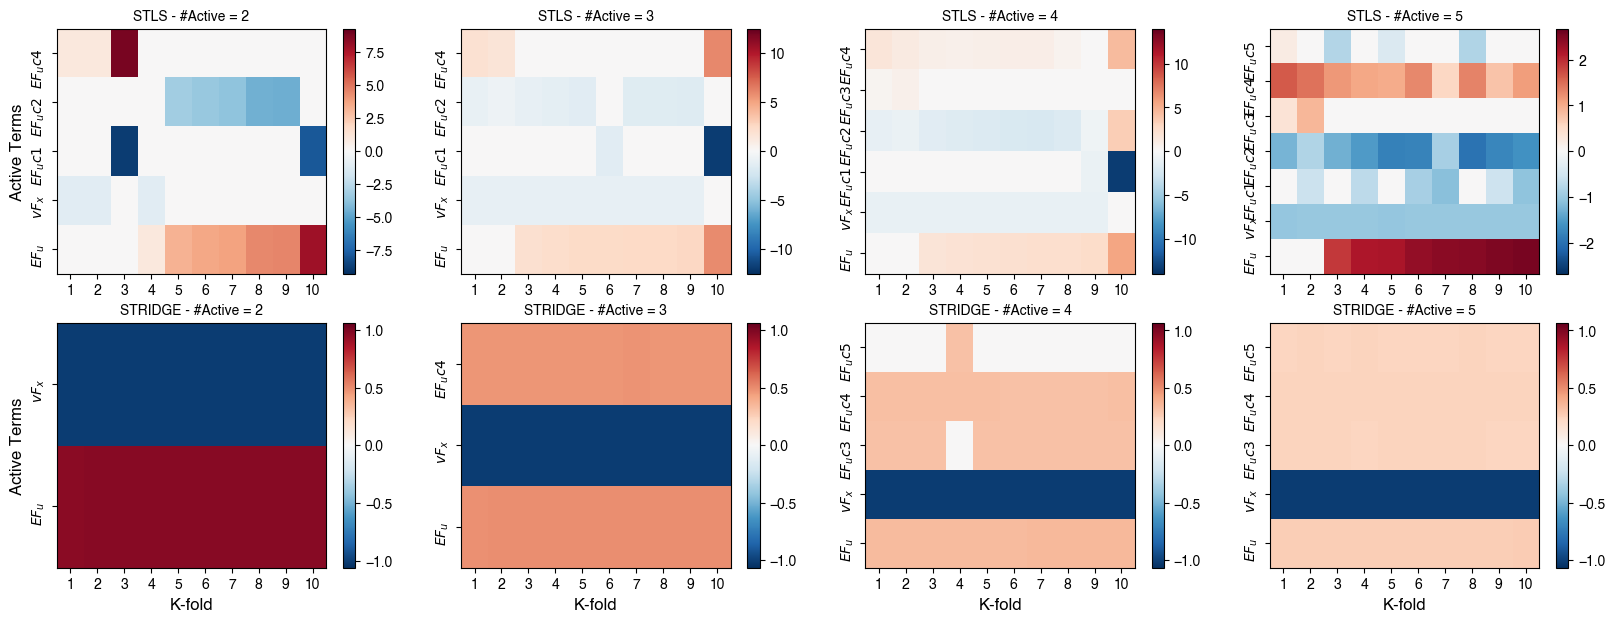

In [14]:
M = [2,3,4,5]

fig, ax = plt.subplots(len(corr_results), len(M), figsize=(len(M)*5,len(corr_results)*3.5))

for ik, key in enumerate(corr_results):
    for im, m in enumerate(M):
        
        ax[ik,im].set_title(key.upper() + ' - #Active = ' + str(m))
        
        unique_Mterm_models = np.unique(corr_results[key]['coeff_evol'][(corr_results[key]['num_non_zero_terms'][:,:] == m)], axis = 0)
        idx_non_zero_coefs_Mterm_models = (np.sum(unique_Mterm_models**2, axis=0)>0)

        max_abs_coef = np.max(np.abs(unique_Mterm_models))
        img = ax[ik,im].imshow(unique_Mterm_models[:,idx_non_zero_coefs_Mterm_models].T, origin='lower',
                   cmap = 'RdBu_r', aspect ='auto', vmin = -1.05*max_abs_coef, vmax = 1.05*max_abs_coef)

        # plt.yticks(range(sum(idx_non_zero_coefs_Mterm_models)), np.array(description)[idx_non_zero_coefs_Mterm_models], rotation='0')
        description_2 = [r'$'+descr +'$' for descr in description_corr]
        ax[ik,im].set_yticks(range(sum(idx_non_zero_coefs_Mterm_models)), np.array(description_2)[idx_non_zero_coefs_Mterm_models], rotation='vertical')
  
        num_unique_models = unique_Mterm_models.shape[0]
        ax[ik,im].set_xlim(-0.5, num_unique_models-0.5)
        ax[ik,im].set_xticks(range(num_unique_models), range(1, num_unique_models+1))
        
        #if im == len(M)-1:
        fig.colorbar(img, ax=ax[ik,im])
    
for a in ax:
    a[0].set_ylabel('Active Terms')

for a in ax[-1]:
    a.set_xlabel('K-fold')

On the plots above we are analyzing the models retrieved for complexities from 2 to 5.

**STLS**
 - It is clear that the LS estimates are wrong due to the introduction of correlated variables. 
 - This happens because the matrix becomes ill-conditioned, so the algorithm produces very different solutions depending on the portion of the data we use.
 - This is especially highlighted by the range of the retrieved parameters (check the colorbar range).

**STRidge**
 - For a model complexity of 2 (correct) the algorithm recovers the expected model.
 - For higher model complexities a grouping effect is observed. Notice that correlated variables share the same weight (even though this is not hard coded), and as one increase the model complexity this weight is diluted across correlated variables.
 - This grouping effect is one of the properties of the ridge regression $\ell_2$-penalty.


These results highlight some of the benefits of ridge regression in stabilizing the sparse regression problem, which in combination with the greedy optimization approach, still allows us to recover the sparsest correct PDE (taking into consideration the retrieved pareto-curves).

***

# LASSO variants for cases with Correlated Variables 

Although not explored in this notebook, there exists a broad range of other regularizations that allow one to do sparse regression with correlated/grouped variables. In particular variants of LASSO which are designed to overcome the non-uniqueness of the standard algorithm in this scenario.

These different approaches can be divided into 2 main groups, one where the grouping is enforced by pre-defining the groups of correlated variables and appears explicitily in the regularization term (let us call it "hard" grouping), and another where this grouping effect is imposed by the regularization term properties without the need to define pre-define/compute groups/clusters of correlated variables ("soft" grouping). Providing a detailed description is outside of the scope of this work, but we will quickly cover some examples and discuss their possible applicability to the case of PDE extraction. A comparison between some of these examples is provided in [[10,14](#bib)].


### "Soft" Grouping Algorithms

One example of regularization terms which promote grouping is the already mentioned **Elastic Net** [[1](#bib)]. As mentioned in the intro the addition of the $\ell_2$ norm causes a grouping effect similar to the one observed for above for ridge regression.

Additionally the **Ordered Weighted L1 Regularization (OWL)** [[11,12](#bib)], a generalization of the the **"Octagonal shrinkage and clustering algorithm for regression" (OSCAR)** [[13](#bib)] norm and also includes the $\ell_1$ and $\ell_\infty$, can also be used for this effect. The OSCAR norm in particular is given by:

\begin{equation} R_{OSCAR}(\mathbf{x}) = \|x\|_1 + \lambda_2 \sum_{i < j} max(|x_i|, |x_j|)\end{equation}

It becomes clearer why this has a grouping effect when visualing the surface defined by the norm (see Figure 2).

Another example is the **Graph Total Variation (GTV)** [[14](#bib)] whose regularization term is given by:

\begin{equation} R_{GTV}(\mathbf{x}) = \|\mathbf{x}\|_1 + + \lambda_t\sum_{j,k}\left|\hat{c}_{jk}\right|^{1/2} \left|x_j - s_{jk}x_k\right| +   \lambda_s\sum_{j,k} \left|\hat{c}_{jk}\right|(x_j - s_{jk}x_k)^2 \end{equation}

where $\mathbf{C}$ is an estimate of the covariance matrix (e.g. computed with the available data $\mathbf{X}$) and $s_{jk} = \text{sign}(c_{jk})$. In this formulla, the second term pushes for small differences between the weight of variables with large covariance (grouping effect), while the third term helps reducing the condition number of $\mathbf{X}$ (similar effect as an $\ell_2$ norm).

Although the grouping capabilities of these methods are interesting, they enforce non-zero weights for all correlated variables which influence the target variable (i.e. less spare solutions). Additionally, they do not explicitely express which variables are correlated since for some scenarios it is possible that disjoint sets of correlated variables share the same coefficient. Therefore, this might reduce the applicability of this class of algorithms for the task of sparse regression for the recovery of PDEs whose main focus is interpretability (however one can always argue that correlations can be pre-computed).

<center><img src="./img/oscar.png" style="width:70%"></center>
<br>
<left><b>Figure 2</b>: Illustration of $\ell_0$, SMAP, LASSO, OSCAR and $\ell_\infty$ penalty functions and their effect in cases with strongly correlated variables (components with large magnitude) and uncorrelated/weakly correlated variables (components with small magnitude). Retrieved from X. Zeng and M. Figueiredo [<a href=https://arxiv.org/pdf/1404.3184.pdf>Source]  </left>

### "Hard" Grouping Algorithms
    
Example of approaches which explicitily take into account groups of correlated variables when performing sparse regression are the **Constrained Representative LASSO (CRL)** and **Constrained Group LASSO (CGL)** algorithms [[15](#bib)]. In both cases variables are clustered before the sparse regression procedure is done (e.g. based on their correlations) and these clusters $G = \{G_i, i=1,..., q\}$ are then explicitely taken into account during the regression process. 
    
For the CRL case the variables are aggregated according to:

\begin{align}
\overline{\mathbf{x}}_i = \frac{1}{|G_i|} \sum_{j \in G_i}\mathbf{x}_j
\end{align}
    
where $\mathbf{x}_j$ denotes the $j$th column-vector of the design matrix $\mathbf{X}$. Afterwards one solves the optimization problem:
    
\begin{equation}
\min_{\mathbf{w} \ \in \ \mathbb{R}^q} \frac{1}{2n} \left\|\overline{\mathbf{X}}\mathbf{w} - \mathbf{y} \right\|^2_2 + \lambda \left\| \mathbf{w}\right\|_1
\end{equation}
    
where $\overline{\mathbf{X}} \in \mathbb{R}^{n\times q}$ correponds to the design matrix after cluster aggregation.
    
For the CGL case no cluster representation is computed and instead the following optimization problem is solved:

\begin{equation}
\min_{\mathbf{w} \ \in \ \mathbb{R}^p} \frac{1}{2n} \left\|\overline{\mathbf{X}}\mathbf{w} - \mathbf{y} \right\|^2_2 + \lambda \sum_{i=1}^q \alpha_i \left\| \mathbf{X}_{G_i} w_i\right\|_2
\end{equation}

where $\overline{\mathbf{X}}_{G_i} \in \mathbb{R}^{n\times |G_i|}$ represents a matrix with the columns $\mathbf{X}$ corresponding to the variables belonging to the $i$th group, and $\alpha_i$ is usually chosen as $\sqrt{|G_i|/n}$.
    
Unlike the "soft" grouping methods in this case the weights are shared across clustered variables. The performance of these methods is however dependent on the correctness of the pre-computed clusters. Nonethless, having the clustering step can be helpful for interpretability in the PDE discovery case, since we know _a-priori_ that two variables are correlated and can be used interchangeable in final symbolic expression.
    

***

# Conclusions

In this tutorial we have covered some of the basics of sparse regression using different regularizations. We have used a plasma physics PDE discovery test-case to illustrate the effect of different regularizations, optimization algorithms, and correlated variables on the retrieved symbolic expression.

Currently there exists a lot of interest from the physics community on using this type of sparse regression methods to have an interpretable model of complex non-linear dynamics for which a formula can not be computed from first principle calculations. These efforts could benefit a lot from the extensive prior work on sparse regression from the statistical learning field. Particularly, by considering different sparse regression algorithms with better guarantees of convergence and robustness against ill-posed posed problems due to the presence of correlated variables.

However, it is not only the regression method that might hinder the performance of sparse regression methods for PDEs. One major source of error is the scarcity of data and the noise introduced by the finite difference schemes usually used to estimate the derivatives. For example, recent work tried to tackle these problems by combining sparse regression techniques with Physics Informed Neural Networks [[16](https://www.nature.com/articles/s41467-021-26434-1)] having achieved interesting results. However there is still significant work to be done on how to make these methods robust enough to the point we can fully trust the recovered equations for cases where no known formulas exist.

***

# References

<a id='bib'></a>

[1] K. Murphy, ["Probabilistic Machine Learning: An introduction"](https://probml.github.io/pml-book/book1.html)<br>
[2] S. Brunton _et al._, ["Discovering governing equations from data by sparse identification of nonlinear dynamical systems."](https://www.pnas.org/doi/10.1073/pnas.1517384113)<br>
[3] S. Rudy _et al._, ["Data-driven discovery of partial differential equations."](https://www.science.org/doi/10.1126/sciadv.1602614)<br>
[4] B. de Silva _et al._, ["PySINDy: A Python package for the sparse identification of nonlinear dynamical systems from data."](https://github.com/dynamicslab/pysindy)<br>
[5] L. Zhang and H. Schaeffer, ["On the convergence of the SINDy algorithm."](https://www.math.cmu.edu/cna/Publications/publications2018/papers/18-CNA-013.pdf)<br>
[6] E. P. Alves and F. Fiúza, ["Two-stream instability dataset from Particle-In-Cell code OSIRIS"](https://zenodo.org/record/7968601)<br>
[7] E. P. Alves and F. Fiúza, ["Data-driven discovery of reduced plasma physics models from fully kinetic simulations"](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.033192)<br> 
[8] J. A. Tropp, and A. C. Gilbert, ["Signal recovery from random measurements via orthogonal matching pursuit."](http://users.cms.caltech.edu/~jtropp/papers/TG07-Signal-Recovery.pdf)<br>
[9] E. Soubies _et al._, ["A Continuous Exact l0 penalty (CEL0) for least squares
regularized problem."](https://inria.hal.science/hal-01102492v2/document)<br>
[10] A Kumar _et al._, ["Numerical characterization of support recovery in sparse regression with correlated design."](https://www.tandfonline.com/doi/full/10.1080/03610918.2022.2050392)<br>
[11] X. Zeng and M. Figueiredo ["Decreasing Weighted Sorted L1 Regularization."](https://arxiv.org/pdf/1404.3184.pdf)<br>
[12] M. Figueiredo and R. Nowak ["Ordered Weighted L1 Regularized Regression with Strongly Correlated Covariates: Theoretical Aspects."](http://proceedings.mlr.press/v51/figueiredo16.pdf)<br>
[13] H. Bondell and J. Reich, ["Simultaneous regression shrinkage, variable selection, and supervised clustering of predictors with OSCAR."](https://pubmed.ncbi.nlm.nih.gov/17608783/)<br>
[14] Y. Li _et al._, ["Graph-based regularization for regression problems with highly-correlated designs."](https://ieeexplore.ieee.org/abstract/document/8646615)<br>
[15] P. Bühlmann _et al._, ["Correlated variables in regression: clustering and sparse estimation."](https://www.sciencedirect.com/science/article/pii/S0378375813001225?via%3Dihub)<br>
[16] Z. Chen _et al._, ["Physics-informed learning of governing equations from scarce data."](https://www.nature.com/articles/s41467-021-26434-1)